<a href="https://colab.research.google.com/github/BasharAZ1/GCN-and-BERT-for-Short-Text-Classification/blob/main/BiLSTM_Arabic_Final_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install flair

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install arabert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install biterm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    |   Package bcp47 is already up-to-dat

True

In [ ]:
from arabert.preprocess import ArabertPreprocessor
from flair.data import Sentence
from flair.embeddings import BertEmbeddings 
import os
import gensim
import spacy
from collections import Counter
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import networkx as nx
from collections import OrderedDict
from itertools import combinations
import math
from tqdm import tqdm
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from sklearn.feature_extraction.text import CountVectorizer
import re, string, unicodedata
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import inflect
from nltk.corpus import stopwords
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
#from pandas.compat.pyarrow import pa
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
pip install keras_preprocessing

     -------------------------------------- 42.6/42.6 kB 688.1 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
hidden_size_1=244 #Size of first GCN hidden layer
hidden_size_2=98 #Size of second GCN hidden layer
num_classes=2 #Number of labels in dataset for prediction
test_ratio=0.0 #Ratio to split training data for testing purpose
num_epochs=500 #No of epochs
lr=0.011 #Learning rate
model_no=0 #Model ID

#GCN_Model is the 2-layer GCN network for the text classification. First layer consists of 244 neurons and second layer
#consists of 98 to predict the final output that is either 0 or 1.
class GCN_MODEL(nn.Module):
    #Initialization function is basically initializing the initial weights of the hidden layerr, setting variables which 
    #is basically the input layer and the initializing the biases of the layers.
    def __init__(self, Indentity_Matrix_size, Adjancy_Matrix_hat, bias=True): #Indentity_Matrix_size are the num of features
        super(GCN_MODEL, self).__init__()                                     
        self.Adjancy_Matrix_hat = torch.tensor(Adjancy_Matrix_hat, requires_grad=False).float()
        self.weight = nn.parameter.Parameter(torch.FloatTensor(Indentity_Matrix_size, 244))
        variables = 2./(self.weight.size(1)+self.weight.size(0))
        self.weight.data.normal_(0,variables)
        self.weight2 = nn.parameter.Parameter(torch.FloatTensor(244, 98))
        variables2 = 2./(self.weight2.size(1)+self.weight2.size(0))
        self.weight2.data.normal_(0,variables2)
        if bias:
            self.bias = nn.parameter.Parameter(torch.FloatTensor(244))
            self.bias.data.normal_(0,variables)
            self.bias2 = nn.parameter.Parameter(torch.FloatTensor(98))
            self.bias2.data.normal_(0,variables2)
        else:
            self.register_parameter("bias", None)
        self.fc1 = nn.Linear(98,2)
        
    ### 2-layer of the GCN model 
    def forward(self, Value): 
        Value = torch.mm(Value, self.weight)
        if self.bias is not None:
            Value = (Value + self.bias)
        Value = F.relu(torch.mm(self.Adjancy_Matrix_hat, Value))
        Value = torch.mm(Value, self.weight2)
        if self.bias2 is not None:
            Value = (Value + self.bias2)
        Value = F.relu(torch.mm(self.Adjancy_Matrix_hat, Value))
        return self.fc1(Value)

In [ ]:
#nCr functions is used to find out the combination of words with other words
#Number of combination is find out usinf the formula nCr which is (factorial(n)/factorial(r)*factorial(n-r))
def nCr(n,r):
    fact = math.factorial
    return int(fact(n)/(fact(r)*fact(n-r)))

#Remove_Stopwords_Characters is a function that takes the data in tokens and list of stopwords and then it remove all
def Remove_Stopwords(Data_Tokens,stopwords):
    Cleaned_Data = []
    for token in Data_Tokens:
        if (token not in stopwords) and (token not in ["،","؟",".",",",";","&","'s", "’",":", "?", "!","(",")","”","“",\
            "'","'m","'no","***","--","...","[","]","–", "@","+","-","``","''"]):
            Cleaned_Data.append(token)
    return Cleaned_Data
  
#Word_Word_Graph_Edges is a function that takes takes the calculated pointwise mutual information calculated and 
#Construct a list of word-word edges having a certain weight which means each index of list will have two words and a weight
def Word_Word_Graph_Edges(PMI_IJ):
    Word_Word_Edges = []
    cols = list(PMI_IJ.columns);
    cols = [str(word) for word in cols]
    for word1, word2 in tqdm(combinations(cols, 2), total=nCr(len(cols), 2)):
        if (PMI_IJ.loc[word1,word2] > 0):
            Word_Word_Edges.append((word1,word2,{"weight":PMI_IJ.loc[word1,word2]}))
    return Word_Word_Edges

def dummy_fun(doc):
    return doc

In [ ]:
import nltk

In [ ]:
print("Loading Train Data And Doing Pre Processing On Data To Clean It")
Path = "./"
dataframe = pd.read_csv(os.path.join(Path,"train.csv")) #Loading data from train.csv
dataframe['author'] = np.where(dataframe['bookName'] == 'Iḥyāʾ ʿulūm al-dīn', 0, dataframe['author'])
dataframe['author'] = np.where(dataframe['bookName'] != 'Iḥyāʾ ʿulūm al-dīn', 1, dataframe['author'])
dataframe.drop(["bookName"], axis=1, inplace=True) #Droping unneccessary coloumns
dataframe = dataframe[["tweet","author"]] #Saving only important coloumns
Corpus_Data=dataframe.dropna() #Dropping null values in the datset
Corpus_Data=Corpus_Data.reset_index(drop=True) #Resetting the indexes
stopwords = list(set(nltk.corpus.stopwords.words("arabic"))) #Finding stopwords using nltk
print(Corpus_Data['tweet'])
print()
#Cleaning data set by removing the stopwords and special characters and converting it into tokens
for i in range(len(Corpus_Data['tweet'])):
    Corpus_Data['tweet'][i] = re.findall(r'[\u0600-\u06FF]+', Corpus_Data['tweet'][i])
    for j in range(len(Corpus_Data['tweet'][i])):
        Corpus_Data['tweet'][i][j] = re.sub(r'[،]', "", Corpus_Data['tweet'][i][j])
    Corpus_Data['tweet'][i] = Remove_Stopwords(Corpus_Data['tweet'][i],stopwords)
    if('' in Corpus_Data['tweet'][i]):
        Corpus_Data['tweet'][i].remove('')
            
print("Cleaned Data")
print((Corpus_Data['tweet']))

data=Corpus_Data.loc[Corpus_Data["author"]==0]
results = set()
data['tweet'].apply(results.update)
for i in range(len(Corpus_Data["tweet"])):
  if(Corpus_Data['author'][i]==1):
    words=[]
    for word in Corpus_Data["tweet"][i]:
      if word not in results:
        words.append(word)
    Corpus_Data["tweet"][i]=words


#Splliting the larger dataset of higher length into smaller to train the bert model 
#Maximum length is 150 that would be gone upto 512 for bert embedding 
for i in range(len(Corpus_Data["tweet"])):
    max_term=75
    remaining=len(Corpus_Data['tweet'][i])-max_term
    First_elements = Corpus_Data["tweet"][i][:max_term]
    if(remaining>0):
        while(remaining>0):
            next_terms=max_term
            max_term+=75
            remaining=len(Corpus_Data['tweet'][i])-max_term
            if(remaining<0):
                Corpus_Data.loc[len(Corpus_Data.index)] = [Corpus_Data["tweet"][i][next_terms:],Corpus_Data["author"][i]]
            else:
                Corpus_Data.loc[len(Corpus_Data.index)] = [Corpus_Data["tweet"][i][next_terms:max_term],Corpus_Data["author"][i]]
    Corpus_Data["tweet"][i]=First_elements
df_cols = ['tweet', 'author']
data=pd.DataFrame(columns=df_cols)
for i in range(len(Corpus_Data['tweet'])):
  if(len(Corpus_Data['tweet'][i])==75):
    data.loc[i] = Corpus_Data.iloc[i]
data=data.reset_index(drop=True) #Resetting the indexes
labelzero = data[data['author']==0]
labelzero=labelzero.reset_index(drop=True) #Resetting the indexes
labelone = data[data['author']==1]
labelone=labelone.reset_index(drop=True) #Resetting the indexes
Corpus_Data=Corpus_Data[0:0]
Corpus_Data=labelzero[0:1000]
Corpus_Data=Corpus_Data.append(labelone[0:1000])
Corpus_Data=Corpus_Data.reset_index(drop=True) #Resetting the indexes
print((Corpus_Data['tweet']))
Corpus_Data['author']=Corpus_Data['author'].astype('Int64')

Loading Train Data And Doing Pre Processing On Data To Clean It
0       ['Book', '1-4', 'بسم', 'الله', 'الرحمن', 'الرح...
1       ['وهو', 'الكتاب', 'العاشر', 'من', 'ربع', 'العب...
2       ['الثامن', 'من', 'ربع', 'المهلكات', 'كتاب', 'ذ...
3       ['حق', 'جلاله', 'حمد', 'الحامدين.', '[1]', 'وأ...
4       ['البصير', 'رد', 'وسلوك', 'طريق', 'الآخرة', 'م...
                              ...                        
1995    ['تلفتي', 'ولو', 'لم', 'أؤد', 'الفرض', 'مني', ...
1996    ['منه', 'ومن', 'كل', 'حيرة', 'ألم', 'يك', 'فيم...
1997    ['بسم', 'الله', 'الرحمن', 'الرحيم', '**الأجوبة...
1998    ['والصفاء', 'تستحق', 'باستعدادها', 'روحا', 'يد...
1999    ['فهو', 'فياض', 'بذاته', 'على', 'كل', 'حقيقة',...
Name: tweet, Length: 2000, dtype: object

Cleaned Data
0       [بسم, الله, الرحمن, الرحيم, وبه, نستعين, تأليف...
1       [الكتاب, العاشر, ربع, العبادات, الربع, الثاني,...
2       [الثامن, ربع, المهلكات, كتاب, ذم, الكبر, والعج...
3       [حق, جلاله, حمد, الحامدين, وأصلى, وأسلم, رسله,...
4       [ال

C:\Users\knowl\AppData\Local\Temp\ipykernel_744\2304140960.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Corpus_Data=Corpus_Data.append(labelone[0:1000])


In [ ]:
print("Loading Test Data And Doing Pre Processing On Data To Clean It")
Path = ""
dataframe = pd.read_csv(os.path.join(Path,"test_Al-Mankhul.csv")) #Loading data from test.csv
dataframe.drop(["bookName"], axis=1, inplace=True) #Droping unneccessary coloumns
#datatest=dataframe["bookName"]
dataframe = dataframe[["tweet","author"]] #Saving only important coloumns
Test_Corpus_Data=dataframe.dropna() #Dropping null values in the datset
Test_Corpus_Data=Test_Corpus_Data.reset_index(drop=True) #Resetting the indexes
stopwords = list(set(nltk.corpus.stopwords.words("arabic"))) #Finding stopwords using nltk
print(Test_Corpus_Data['tweet'])
print()
#Cleaning data set by removing the stopwords and special characters and converting it into tokens
for i in range(len(Test_Corpus_Data['tweet'])):
  Test_Corpus_Data['tweet'][i] = re.findall(r'[\u0600-\u06FF]+', Test_Corpus_Data['tweet'][i])
  for j in range(len(Test_Corpus_Data['tweet'][i])):
    Test_Corpus_Data['tweet'][i][j] = re.sub(r'[،]', "", Test_Corpus_Data['tweet'][i][j])
  Test_Corpus_Data['tweet'][i] = Remove_Stopwords(Test_Corpus_Data['tweet'][i],stopwords)
  if("" in Test_Corpus_Data['tweet'][i]):
    Test_Corpus_Data['tweet'][i].remove("")

Test_Corpus_Data['author'] = np.where(Test_Corpus_Data['author'] == 'Al Ghazali', 0, Test_Corpus_Data['author'])
Test_Corpus_Data['author'] = np.where(Test_Corpus_Data['author'] != 0, 1, Test_Corpus_Data['author'])
print("Cleaned Data")
print(Test_Corpus_Data['tweet'])


data=Test_Corpus_Data.loc[Test_Corpus_Data["author"]==0]
results = set()
data['tweet'].apply(results.update)
for i in range(len(Test_Corpus_Data["tweet"])):
  if(Test_Corpus_Data['author'][i]==1):
    words=[]
    for word in Test_Corpus_Data["tweet"][i]:
      if word not in results:
        words.append(word)
    Test_Corpus_Data["tweet"][i]=words

#Splliting the larger dataset of higher length into smaller to train the bert model 
#Maximum length is 150 that would be gone upto 512 for bert embedding 
for i in range(len(Test_Corpus_Data["tweet"])):
  max_term=75
  remaining=len(Test_Corpus_Data['tweet'][i])-max_term
  First_elements = Test_Corpus_Data["tweet"][i][:max_term]
  if(remaining>0):
    while(remaining>0):
      next_terms=max_term
      max_term+=75
      remaining=len(Test_Corpus_Data['tweet'][i])-max_term
      if(remaining<0):
        Test_Corpus_Data.loc[len(Test_Corpus_Data.index)] = [Test_Corpus_Data["tweet"][i][next_terms:],Test_Corpus_Data["author"][i]]
      else:
        Test_Corpus_Data.loc[len(Test_Corpus_Data.index)] = [Test_Corpus_Data["tweet"][i][next_terms:max_term],Test_Corpus_Data["author"][i]]
  Test_Corpus_Data["tweet"][i]=First_elements
df_cols = ['tweet', 'author']
data=pd.DataFrame(columns=df_cols)
for i in range(len(Test_Corpus_Data['tweet'])):
  if(len(Test_Corpus_Data['tweet'][i])==75):
    data.loc[i] = Test_Corpus_Data.iloc[i]
data=data.reset_index(drop=True) #Resetting the indexes
#labelzero = data[data['author']==0]
#labelzero=labelzero.reset_index(drop=True) #Resetting the indexes
#labelone = data[data['author']==1]
#labelone=labelone.reset_index(drop=True) #Resetting the indexes
#Test_Corpus_Data=Test_Corpus_Data[0:0]
#Test_Corpus_Data=labelzero[0:250]
#Test_Corpus_Data=Test_Corpus_Data.append(labelone[0:250])
Test_Corpus_Data=Test_Corpus_Data.reset_index(drop=True) #Resetting the indexes
print(Test_Corpus_Data["tweet"])

Loading Test Data And Doing Pre Processing On Data To Clean It
0      ['بسم', 'الله', 'الرحمن', 'الرحيم', 'الحمد', '...
1      ['المدلول', 'وطلب', 'الدليل', 'مع', 'الذهول', ...
2      ['الأحكام', 'الشرعية', 'ليست', 'أحكام', 'الأفع...
3      ['لا', 'يتصور', 'فيها', 'الخلاف', 'بين', 'العق...
4      ['لا', 'يميز', 'بينهما', 'والمختلفان', 'في', '...
                             ...                        
255    ['بالمثقل', 'خيفة', 'انتهاضه', 'ذريعة', 'إلى',...
256    ['الوجه', 'ومسلكه', 'في', 'مسألة', 'الإبدال', ...
257    ['التكبير', 'بترجمته', 'تركيا', 'أو', 'هنديا',...
258    ['القصاص', 'بالقتل', 'بالمثقل', 'فمهد', 'التخن...
259    ['أليهم', 'هذه', 'الواقعة', 'لكانوا', 'لا', 'ي...
Name: tweet, Length: 260, dtype: object

Cleaned Data
0      [بسم, الله, الرحمن, الرحيم, الحمد, لله, رب, ال...
1      [المدلول, وطلب, الدليل, الذهول, المدلول, تأباه...
2      [الأحكام, الشرعية, أحكام, الأفعال, صفات, ذاتية...
3      [يتصور, الخلاف, العقلاء, نسبونا, عناد, عكسنا, ...
4      [يميز, بينهما, والمخت

In [ ]:
print("Calculating Tf-idf Using The Corpus")
#Calculating the Tf-idf using the TfidfVectorizer
Tfidfvector = TfidfVectorizer(input="content", max_features=None, tokenizer=dummy_fun, preprocessor=dummy_fun)
Tfidfvector.fit(Corpus_Data["tweet"])
Corpus_tfidf = Tfidfvector.transform(Corpus_Data["tweet"])
Corpus_tfidf = Corpus_tfidf.toarray() #Converting Tfidf into array 
Corpus_Vocab = Tfidfvector.get_feature_names() #Getting vocabulary of the dataset
Corpus_Vocab = np.array(Corpus_Vocab) #Saving the vocabulary in the np array
Corpus_tfidf = pd.DataFrame(Corpus_tfidf,columns=Corpus_Vocab) #Creating datafram for the Tfidf using the vocabulary
blankIndex=[''] * len(Corpus_tfidf)
Corpus_tfidf.index=blankIndex
print(Corpus_tfidf)

Calculating Tf-idf Using The Corpus


c:\Users\knowl\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


           ؛  ؟فقال  ؟فقلت  ؟فمن  ءسمًا  آباءهم  آبائنا  آبائه  آبائهم  ...  \
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
..  ...  ...    ...    ...   ...    ...     ...     ...    ...     ...  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   
    0.0  0.0    0.0    0.0   0.0    0.0     0.0     0.0    0.0     0.0  ...   

    َعَنٌا    ُ  ُالُمقَرَّبِينَ  ُعلى    ِ  ِجَرُّ

c:\Users\knowl\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Creating Co-occurencces of the words in the dataset 
Corpus_Names = Corpus_Vocab
Total_Window_Length=2000
Occurrences_i  = OrderedDict((name, 0) for name in Corpus_Names)
word_word = OrderedDict( (name,index) for index,name in enumerate(Corpus_Names) )
Co_Occurrences = np.zeros( (len(Corpus_Names),len(Corpus_Names)) ,dtype=np.int8)
Number_Of_Windows = 0; 
print("Calculating Co-Occurences")
for l in tqdm(Corpus_Data["tweet"], total=len(Corpus_Data["tweet"])):
    for i in range(len(l)-Total_Window_Length):
        Number_Of_Windows += 1
        data = set(l[i:(i+Total_Window_Length)])
        for word in data:
            Occurrences_i[word] += 1
        for word1,word2 in combinations(data,2):
            index1 = word_word[word1]
            index2 = word_word[word2]
            Co_Occurrences[index1][index2] += 1
            Co_Occurrences[index2][index1] += 1

print(Co_Occurrences)

Calculating Co-Occurences


100%|██████████| 2000/2000 [00:00<00:00, 575705.72it/s]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [ ]:
print("Calculating Pointwise Mutual Information")
#Converting that Co-ocurrence into Pointwise mutual information
PMI_IJ = pd.DataFrame(Co_Occurrences, index = Corpus_Names,columns=Corpus_Names)/Number_Of_Windows
del(Co_Occurrences)
PMI_I = pd.Series(Occurrences_i, index=Occurrences_i.keys())/Number_Of_Windows
del(Occurrences_i)
minimim_value=int(len(PMI_IJ.columns)/10)
minimim=minimim_value
Last=0

Calculating Pointwise Mutual Information


In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI First Half")
#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

Calculating PMI First Half


In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI Second Half")

#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

Calculating PMI Second Half


In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI Third Half")

#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI Forth Half")
#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

Calculating PMI Forth Half


In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI Fifth Half")

#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

Calculating PMI Fifth Half


In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI Sixth Half")

#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

Calculating PMI Sixth Half


In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI Seventh Half")

#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

Calculating PMI Seventh Half


In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI Eigth Half")

#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

Calculating PMI Eigth Half


In [ ]:
pmicol=PMI_IJ.columns[Last:minimim_value]
pmiindx=PMI_IJ.index[Last:minimim_value]
print("Calculating PMI Ninth Half")

#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)

Calculating PMI Ninth Half


In [ ]:
pmicol=PMI_IJ.columns[Last:]
pmiindx=PMI_IJ.index[Last:]
print("Calculating PMI Final Half")

#Calculating the PMI
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col]/PMI_I[col]
for row in pmiindx:
    PMI_IJ.loc[row,:] = PMI_IJ.loc[row,:]/PMI_I[row]
#Adding 1e-9(0.000000001) to the PMI Array if any value is zero, replacing nan values also with 1e-9, and negative values
#To avoid errors 
PMI_IJ = PMI_IJ + 1E-9
PMI_IJ = PMI_IJ.replace(np.nan,1E-9 , regex=True)
PMI_IJ[PMI_IJ < 0] = 1E-9 
for col in pmicol:
    PMI_IJ[col] = PMI_IJ[col].apply(lambda x: math.log(x))

Last=minimim_value
minimim_value+=minimim
del(pmicol)
del(pmiindx)
del(PMI_I)
blankIndex=[''] * len(PMI_IJ)
PMI_IJ.index=blankIndex
print(PMI_IJ)

Calculating PMI Final Half
                             ؛         ؟فقال         ؟فقلت          ؟فمن  \
    9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09   
    9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09   
    9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09   
    9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09   
    9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09  9.000000e-09   
..           ...           ...           ...           ...           ...   
    1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09   
    1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09   
    1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09   
    1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09   
    1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09  1.000000e-09   

           ءسمًا        آباءهم        آبائنا         آبائه  

In [ ]:
#Import below packages if using google colab 
from biterm.cbtm import oBTM 
from biterm.utility import vec_to_biterms, topic_summuary # helper functions
import numpy as np
#Initializing Count Vector to generate biterms
biterm_vector = CountVectorizer(input="content", max_features=None, tokenizer=dummy_fun, preprocessor=dummy_fun)
#Getting features
Corpus_Data1=Corpus_Data.iloc[:100]
Corpus_Features = biterm_vector.fit_transform(Corpus_Data1["tweet"]).toarray()
Biterms = vec_to_biterms(Corpus_Features)
#Building the biterms model
Biterm_Model = oBTM(num_topics=2, V=Corpus_Vocab)
 #Training the Biterm Model
Predicted_Topics = Biterm_Model.fit_transform(Biterms, iterations=1)

for x in range (0,len(Corpus_Data)-100,100):
                                  Corpus_Data1=Corpus_Data.iloc[x+100:x+199]
                                  print(x)
                                  Corpus_Features = biterm_vector.fit_transform(Corpus_Data1["tweet"]).toarray()
                                  Biterms = vec_to_biterms(Corpus_Features)
                                  #Building the biterms model
                                  Biterm_Model = oBTM(num_topics=2, V=Corpus_Vocab)
                                  #Training the Biterm Model
                                  Predicted_Topics1 = Biterm_Model.fit_transform(Biterms, iterations=1)
                                  Predicted_Topics=np.append(Predicted_Topics,Predicted_Topics1)
                                  
print("\n\n Topic coherence ..")
Topics_Details=topic_summuary(Biterm_Model.phi_wz.T, Corpus_Features, Corpus_Vocab, 10)
#Printing Output Generate And topics find by the biterm model
print("Texts & Topics")
for i in range(len(Corpus_Data["tweet"])):
    print("{} (topic: {})".format(Corpus_Data["tweet"][i], Predicted_Topics[i].argmax()))


del(Biterms)
del(Corpus_Features)
del(biterm_vector)
del(Biterm_Model)

<ipython-input-43-252a8d460837>:14: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Predicted_Topics = Biterm_Model.fit_transform(Biterms, iterations=1)
100%|██████████| 1/1 [02:21<00:00, 141.93s/it]


0


<ipython-input-43-252a8d460837>:24: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Predicted_Topics1 = Biterm_Model.fit_transform(Biterms, iterations=1)
100%|██████████| 1/1 [02:19<00:00, 139.02s/it]


100


100%|██████████| 1/1 [02:34<00:00, 154.36s/it]


200


100%|██████████| 1/1 [02:49<00:00, 169.61s/it]


300


100%|██████████| 1/1 [02:51<00:00, 171.93s/it]


Streaming output truncated to the last 5000 lines.
4       [البصير, رد, وسلوك, طريق, الآخرة, كثرة, الغوائ...
                              ...                        
1995    [جبينه, فمزج, بالبطيخ, ماءً, وعسلاً, وخلاَّ, ف...
1996    [روحانية, عالية, كالقلم, كاللوح, نوعية, قبا, و...
1997    [فهماً, مغلوب, سؤاله, واعتراضه, وتعنت, سؤاله, ...
1998    [حينئذ, يحكي, خيالا, مأخوذا, كالأثافي, فمان, ا...
1999    [ملكة, غلبتها, كالطيش, الحدة, المآكل, والمشارب...
Name: tweet, Length: 500, dtype: object (topic: 0)
0       [بسم, الله, الرحمن, الرحيم, وبه, نستعين, تأليف...
1       [الكتاب, العاشر, ربع, العبادات, الربع, الثاني,...
2       [الثامن, ربع, المهلكات, كتاب, ذم, الكبر, والعج...
3       [حق, جلاله, حمد, الحامدين, وأصلى, وأسلم, رسله,...
4       [البصير, رد, وسلوك, طريق, الآخرة, كثرة, الغوائ...
                              ...                        
1995    [جبينه, فمزج, بالبطيخ, ماءً, وعسلاً, وخلاَّ, ف...
1996    [روحانية, عالية, كالقلم, كاللوح, نوعية, قبا, و...
1997    [فهماً, مغلوب, سؤاله

In [ ]:
#Building the graph using nx package
print("Building Graph For GCN Model (No. of document, word nodes: %d, %d)" %(len(Corpus_tfidf.index), len(Corpus_Vocab)))
GCN_Graph = nx.Graph()
print("Adding Document Nodes To The GCN Graph")
GCN_Graph.add_nodes_from(Corpus_tfidf.index) #First adding document nodes to the graph
print("Adding Word Nodes To The GCN Graph")
GCN_Graph.add_nodes_from(Corpus_Vocab) #Now adding word nodes to the graph
#Getting topics
Topics=Corpus_Data['author'].unique()
Topics = ["Topic "+str(x) for x in Topics]
Topics_Details["Topics"]=Topics
print("Adding Topic Nodes To The GCN Graph")
GCN_Graph.add_nodes_from(Topics) #Now adding topic nodes to the graph where nodes are the value of coherence of a certain topic
#After adding nodes now first create edges between document-word pairs
print("Building Document-Word Edges For The GCN Graph")
Document_Word_Edges = [(document,word,{"weight":Corpus_tfidf.loc[document,word]}) for document in tqdm(Corpus_tfidf.index, total=len(Corpus_tfidf.index))\
                  for word in Corpus_tfidf.columns]
#After creating document-words edges now creating word-word edges in the graph
print("Building Word-Word Edges For The GCN Graph")
Word_Word_Edges = Word_Word_Graph_Edges(PMI_IJ)
print("Building Document-Topic Edges For The GCN Graph")
Document_Topic_Edges=[]
for i in range(len(Corpus_Data["tweet"])):
    Document_Topic_Edges.append((i,Topics[Predicted_Topics[i].argmax()],{"weight":Predicted_Topics[i].max()}))
print("Adding Document-Word, Word-Word Edges, Document-Topic Edges,and Word-Topic Edges To The GCN Graph")
print("Building Word-Topic Edges For The GCN Graph")
Word_Topic_Edges=[]
Topic_list=list(Topics_Details.values())
for i in range(1,len(Topic_list)-1):
    for j in range(len(Topic_list[i])):
        Vector = TfidfVectorizer(input="content", max_features=2, tokenizer=dummy_fun, preprocessor=dummy_fun)
        Vector.fit(Topic_list[i][j])      
        Corpus_vectr = Vector.transform(Topic_list[i][j])
        Corpus_vectr = Corpus_vectr.toarray() 
        Corpus_vectr = pd.DataFrame(Corpus_vectr,columns=Topic_list[i+1])
        for k in range(len(Topic_list[i][j])):
            Word_Topic_Edges.append((Topic_list[i][j][k],Topic_list[i+1][j],{"weight":Corpus_vectr.iloc[k][j]}))
print("Adding Document-Word, Word-Word Edges, Document-Topic Edges, and Word-Topic Edges To The GCN Graph")
#Adding Edges to the graph
GCN_Graph.add_edges_from(Document_Word_Edges)
GCN_Graph.add_edges_from(Word_Word_Edges)
GCN_Graph.add_edges_from(Document_Topic_Edges)
GCN_Graph.add_edges_from(Word_Topic_Edges)
print("Graph Is Constructed Successfully")

del(PMI_IJ)
del(Predicted_Topics)
del(Topics_Details)
del(Word_Topic_Edges)
del(Document_Word_Edges)
del(Document_Topic_Edges)
del(Word_Word_Edges)

Building Graph For GCN Model (No. of document, word nodes: 2000, 7469)
Adding Document Nodes To The GCN Graph
Adding Word Nodes To The GCN Graph
Adding Topic Nodes To The GCN Graph
Building Document-Word Edges For The GCN Graph




  0%|          | 0/2000 [00:00<?, ?it/s]

 11%|█         | 223/2000 [00:00<00:00, 2223.39it/s]

 22%|██▏       | 446/2000 [00:00<00:00, 1948.92it/s]

 33%|███▎      | 656/2000 [00:00<00:00, 2010.30it/s]

 43%|████▎     | 859/2000 [00:00<00:00, 1843.66it/s]

 52%|█████▏    | 1046/2000 [00:00<00:00, 1746.38it/s]

 63%|██████▎   | 1267/2000 [00:00<00:00, 1883.96it/s]

 75%|███████▌  | 1504/2000 [00:00<00:00, 2030.88it/s]

 86%|████████▌ | 1723/2000 [00:00<00:00, 2074.87it/s]

100%|██████████| 2000/2000 [00:01<00:00, 1965.51it/s]


Building Word-Word Edges For The GCN Graph




100%|██████████| 19885/19885 [00:00<00:00, 1253286.88it/s]


Building Document-Topic Edges For The GCN Graph
Adding Document-Word, Word-Word Edges, Document-Topic Edges,and Word-Topic Edges To The GCN Graph
Building Word-Topic Edges For The GCN Graph
Adding Document-Word, Word-Word Edges, Document-Topic Edges, and Word-Topic Edges To The GCN Graph
Graph Is Constructed Successfully


In [ ]:
import pickle
GCN_Graph=pickle.load( open( 'E:\\GCN_Graph1.P', "rb" ) )


In [ ]:
#Building_Matrix_And_Spiliting_Data is a fucntion used to create the indentity matrix which is used as a input in GCN Model
#And also the used for spiliting the data into train and test set to predict the outcomes
def Building_Matrix_And_Spiliting_Data():
    print("Building adjacency and degree matrices...")
    #Creating adjacency matrix of the GCN graph 
    AdjMatrix = nx.to_numpy_matrix(GCN_Graph, weight="weight",dtype=object);
    
    AdjMatrix = AdjMatrix + np.eye(GCN_Graph.number_of_nodes())
    #Creating degree matrix of the GCN graph 
    DegreeMatrix = []
    for degree in GCN_Graph.degree(weight=None):
        if degree == 0 or degree[1] == 0:
            DegreeMatrix.append(0)
        else:
            DegreeMatrix.append(degree[1]**(-0.5))
    DegreeMatrix = np.diag(DegreeMatrix)
    #Features are just saved in the identity matrix
    Identity_Matrix = np.eye(GCN_Graph.number_of_nodes()) 
    AdjMatrix_hat = DegreeMatrix@AdjMatrix@DegreeMatrix#Transformed adjacency matrix 
    Func_Input = Identity_Matrix #Input for GCN network
    print("Collecting Labels For Training")
    #Splitting the train and test data according to the test ratio define
    Test_Sample = []
    for label in Corpus_Data["author"].unique():
        Temp = Corpus_Data[Corpus_Data["author"] == label]
        if len(Temp) >= 4: 
            Test_Sample.extend(list(np.random.choice(Temp.index, size=round(test_ratio*len(Temp)), replace=False)))
    #Select only certain labelled nodes for semi-supervised GCN
    Data_Selected = []
    for i in range(len(Corpus_Data)):
        if i not in Test_Sample:
            Data_Selected.append(i)
    
    #Selecting the train sample from the dataset 
    GCN_Input_selected = Func_Input[Data_Selected]; 
    GCN_Input_selected = torch.from_numpy(GCN_Input_selected).float()
    GCN_Input_Labels_Selected = [l for label, l in enumerate(Corpus_Data["author"]) if label in Data_Selected]
    #Selecting the test sample from the dataset 
    GCN_Input_Not_Selected = Func_Input[Test_Sample]; 
    GCN_Input_Not_Selected = torch.from_numpy(GCN_Input_Not_Selected).float()
    GCN_Input_Labels_Not_Selected = [l for label, l in enumerate(Corpus_Data["author"]) if label not in Data_Selected]
    Final_GCN_Input = torch.from_numpy(Func_Input).float()
    print("%d Train Labels." % (len(GCN_Input_Labels_Selected)))
    return Final_GCN_Input, Identity_Matrix, AdjMatrix_hat, Data_Selected, GCN_Input_Labels_Selected, GCN_Input_Labels_Not_Selected, Test_Sample
    

In [ ]:
#Calling the Building_Matrix_And_Spiliting_Data to find the final input for network and getting train sample
Final_GCN_Input, Identity_Matrix, AdjMatrix_hat, Data_Selected, GCN_Input_Labels_Selected, GCN_Input_Labels_Not_Selected, Test_Sample = Building_Matrix_And_Spiliting_Data()
#Creating the gcn model and given them the final input or features list which is in identity matrix 
GCN_Network = GCN_MODEL(Identity_Matrix.shape[1], AdjMatrix_hat)
GCN_Network_Criterion = nn.CrossEntropyLoss() #Loss Function 
GCN_Network_Optimizer = optim.Adam(GCN_Network.parameters(), lr=lr)
GCN_Network_Scheduler = optim.lr_scheduler.MultiStepLR(GCN_Network_Optimizer, milestones=[1000,2000,3000,4000,5000,6000], gamma=0.77)    
print("Training The GCN Model")
GCN_Network.train() # Training the model
#Loop runs for the number epochs define 
for epoch in range(0, num_epochs):
    GCN_Network_Optimizer.zero_grad()
    #Predicting the output using the gcn model
    Predicted_Output = GCN_Network(Final_GCN_Input)
    #Finding the loss
    Network_Loss = GCN_Network_Criterion(Predicted_Output[Data_Selected], torch.tensor(GCN_Input_Labels_Selected).long())
    Network_Loss.backward()
    GCN_Network_Optimizer.step()
    if epoch % 50 == 0:
        GCN_Network.eval()
        with torch.no_grad():
            Predicted_Labels = GCN_Network(Final_GCN_Input)
        print("[Epoch %d]: " % (epoch))
        print("Predicted Labels Of Trained Nodes: \n", Predicted_Output[Data_Selected].max(1)[1])
        #Trainig again model to give more accurracy
        GCN_Network.train()
    GCN_Network_Scheduler.step()

del(Final_GCN_Input)
del(Identity_Matrix)
del(AdjMatrix_hat)
del(Data_Selected)
del(GCN_Input_Labels_Selected)
del(GCN_Input_Labels_Not_Selected)
del(Test_Sample)
del(GCN_Network)
del(GCN_Network_Criterion)
del(GCN_Network_Optimizer)
del(GCN_Network_Scheduler)

In [ ]:
#Getting the word node representation from used for the gcn model for the train dataset
counter=0
node_representation=[]
for text in Corpus_Data["tweet"]:
  list_representation=[]
  for i in range(len(text)):
    list_representation.append(Corpus_tfidf[text[i]][counter])
  node_representation.append(list_representation)
  counter+=1

#Getting word represtation for the word nodes for the test data
Test_Tfidfvector = TfidfVectorizer(input="content", max_features=None, tokenizer=dummy_fun, preprocessor=dummy_fun)
Test_Tfidfvector.fit(Test_Corpus_Data["tweet"])
Test_Corpus_tfidf = Test_Tfidfvector.transform(Test_Corpus_Data["tweet"])
Test_Corpus_tfidf = Test_Corpus_tfidf.toarray() #Converting Tfidf into array 
Test_Corpus_Vocab = Test_Tfidfvector.get_feature_names() #Getting vocabulary of the dataset
Test_Corpus_Vocab = np.array(Test_Corpus_Vocab) #Saving the vocabulary in the np array
Test_Corpus_tfidf = pd.DataFrame(Test_Corpus_tfidf,columns=Test_Corpus_Vocab) #Creating datafram for the Tfidf using the vocabulary


tcounter=0
test_node_representation=[]
for text in Test_Corpus_Data["tweet"]:
  test_list_representation=[]
  for i in range(len(text)):
    test_list_representation.append(Test_Corpus_tfidf[text[i]][tcounter])
  test_node_representation.append(test_list_representation)
  tcounter+=1

del(Test_Corpus_tfidf)
del(Corpus_tfidf)

/usr/local/lib/python3.8/dist-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
#Prepare model input for bilstm function get the train data, test data, and their word representaion 
#for test and train with max sequence length and vocabulary length.
#This function build the dictionary for the words having bert embedding and also have a word index
#having particular token id for each word.
#First function create bert embedding and build the dictonarty for train and than for the test 
#dataset and at the end concatenate the bert embedding with the word representaions
def Prepare_Model_Input_For_BILSTM(train_data,test_data,node_representation,test_node_representation,Vocab_size=75000,Max_Tweet_Length=75):
    np.random.seed(7)
    model_name="aubmindlab/bert-base-arabertv02"
    AraBert_Tokenizer = BertTokenizer.from_pretrained(model_name)
    Train_Text_Input=[]
    Word_Ids={}
    AraBert_Embedding_Dictionary={}
    #For train dataset
    for tweet in train_data:
      Marked_tweet = "[CLS] " + " ".join(tweet) + " [SEP]"
      #Tokenizing the Marked_tweet using bert tokenizer
      Tweet_tokens = AraBert_Tokenizer.tokenize(Marked_tweet)
      #Getting Bert Token Ids
      Tweet_Token_Ids = AraBert_Tokenizer.convert_tokens_to_ids(Tweet_tokens)
      #Adding Token and its adding to dictionary
      for i in range(len(Tweet_Token_Ids)):
        Word_Ids[Tweet_tokens[i]]=Tweet_Token_Ids[i]
      #Getting Bert Eebedding for input
      Train_Text_Input.append(Tweet_Token_Ids)
      #Getting Words Bert Embedding

      tweet_sample = Sentence(" ".join(tweet))
      AraBert_Embedding = BertEmbeddings()
      AraBert_Embedding.embed(tweet_sample)
      for tweet_token in tweet_sample:
        AraBert_Embedding_Dictionary[tweet_token.text]=tweet_token.embedding.cpu().numpy()
    
    #For test dataset
    Test_Text_Input=[]
    for tweet in test_data:
      Marked_tweet = "[CLS] " + " ".join(tweet) + " [SEP]"
      #Tokenizing the Marked_tweet using bert tokenizer
      Tweet_tokens = AraBert_Tokenizer.tokenize(Marked_tweet)
      #Getting Bert Token Ids
      Tweet_Token_Ids = AraBert_Tokenizer.convert_tokens_to_ids(Tweet_tokens)
      #Adding Token and its adding to dictionary      
      for i in range(len(Tweet_Token_Ids)):
        Word_Ids[Tweet_tokens[i]]=Tweet_Token_Ids[i]
      #Getting Bert Eebedding for input
      Test_Text_Input.append(Tweet_Token_Ids)
      #Getting Words Bert Embedding

      Tweet_sample = Sentence(" ".join(tweet))
      AraBert_Embedding = BertEmbeddings()
      AraBert_Embedding.embed(Tweet_sample)
      for token_token in Tweet_sample:
        AraBert_Embedding_Dictionary[token_token.text]=token_token.embedding.cpu().numpy()

    #Concatenating Train data bert word embeding and word node representation used in gcn 
    for i in range(len(Train_Text_Input)):
      Train_Text_Input[i]=Train_Text_Input[i]+node_representation[i]
    #Concatenating Test data bert word embeding and word node representation used in gcn 
    for i in range(len(Test_Text_Input)):
      Test_Text_Input[i]=Test_Text_Input[i]+test_node_representation[i]

    #Train and Test data is splitting/adusting if smaller than the max tweet length which is 300
    Train_Text_Input = pad_sequences(Train_Text_Input, maxlen=Max_Tweet_Length)
    Test_Text_Input = pad_sequences(Test_Text_Input, maxlen=Max_Tweet_Length)

    #Returning the train input, test input, word id dictionary and word embedding dictionary
    return (Train_Text_Input, Test_Text_Input, Word_Ids, AraBert_Embedding_Dictionary)

In [ ]:
#Function that take word to id dictionary and word to embedding dictionary with embedding dimension,
#tweet length, number of classes, number of layers, dropout to build the bilsmt sequential model 
def Build_BILSTM_Model(Word_Id, Bert_Embedding_Dictionary, Number_Of_Classes,  Max_Tweet_Length=75, Embedding_Dimensions=3072, Dropout_Value=0.5, Number_Of_Hidden_Layer = 3, LSTM_NODES = 32):
    # Initialize a sequebtial model
    BILSTM_MODEL = Sequential()
    # Make the embedding matrix using the embedding_dict
    Weight_Embedding_Matrix = np.random.random((len(Word_Id) + 1, Embedding_Dimensions))
    Dictionary_Length=len(Word_Id)
    iterator=0
    #Find the embedding of each word from the word id dictionary and save the embedding to the
    #Embdedding Matrix
    for word, i in Word_Id.items():
        if(iterator==Dictionary_Length):
          break
        Final_Embedding_Vector = Bert_Embedding_Dictionary.get(word)
        if Final_Embedding_Vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(Weight_Embedding_Matrix[iterator]) != len(Final_Embedding_Vector):
                print("could not broadcast input array from shape", str(len(Weight_Embedding_Matrix[i])),
                      "into shape", str(len(Final_Embedding_Vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file")
                exit(1)
            Weight_Embedding_Matrix[iterator] = Final_Embedding_Vector
        iterator+=1
            
    # Add embedding layer to the model
    BILSTM_MODEL.add(Embedding(len(Word_Id) + 1,
                                Embedding_Dimensions,
                                weights=[Weight_Embedding_Matrix],
                                input_length=Max_Tweet_Length,
                                trainable=True))
    # Add hidden layers to the models
    for i in range(0,Number_Of_Hidden_Layer):
        # Add a bidirectional lstm layer to the model
        BILSTM_MODEL.add(Bidirectional(LSTM(LSTM_NODES, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer to the model
        BILSTM_MODEL.add(Dropout(Dropout_Value))
    BILSTM_MODEL.add(Bidirectional(LSTM(LSTM_NODES, recurrent_dropout=0.2)))
    BILSTM_MODEL.add(Dropout(Dropout_Value))
    # Add the fully connected layer with 256 nurons and relu activation to the model
    BILSTM_MODEL.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes to the model
    BILSTM_MODEL.add(Dense(Number_Of_Classes, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy to the model
    BILSTM_MODEL.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return BILSTM_MODEL

In [ ]:
Train_Text_Input = Corpus_Data.tweet
Train_Label_Input = Corpus_Data.author
Test_Text_Input = Test_Corpus_Data.tweet
Test_Label_Input = Test_Corpus_Data.author

print("Preparing model input by caling the prepare model input for bilstm function")
Train_For_Model, Test_For_Predict, Word_Id, Bert_Embedding_Dictionary = Prepare_Model_Input_For_BILSTM(Train_Text_Input,Test_Text_Input,node_representation,test_node_representation)
#Spiliting the train data for training the model
Train_For_Model, Test_For_Model, Label_train, Label_test = train_test_split(Train_For_Model, Train_Label_Input, test_size = 0.1)
print("Done!")

In [ ]:
Train_For_Model=Train_For_Model.astype('float32')
Test_For_Model=Test_For_Model.astype('float32')
Label_train=Label_train.astype('float32')
Label_test=Label_test.astype('float32')
Test_For_Predict=Test_For_Predict.astype('float32')
Test_Label_Input=Test_Label_Input.astype('float32')

In [ ]:
print("Building Model!")
BILSTM_MODEL = Build_BILSTM_Model(Word_Id, Bert_Embedding_Dictionary, 2)

In [ ]:
print("Fitting The Model!")
BILSTM_MODEL_History = BILSTM_MODEL.fit(Train_For_Model, Label_train,
                           validation_data=(Test_For_Model,Label_test),
                           epochs=100,
                           batch_size=128,
                           verbose=1)

Fitting The Model!
Epoch 1/100
15/15 [==============================] - 61s 4s/step - loss: 0.4515 - accuracy: 0.8356 - val_loss: 0.6244 - val_accuracy: 0.7300
Epoch 2/100
15/15 [==============================] - 61s 4s/step - loss: 0.4529 - accuracy: 0.8356 - val_loss: 0.6059 - val_accuracy: 0.7300
Epoch 3/100
15/15 [==============================] - 63s 4s/step - loss: 0.4514 - accuracy: 0.8356 - val_loss: 0.6198 - val_accuracy: 0.7300
Epoch 4/100
15/15 [==============================] - 66s 4s/step - loss: 0.4543 - accuracy: 0.8356 - val_loss: 0.6204 - val_accuracy: 0.7300
Epoch 5/100
15/15 [==============================] - 63s 4s/step - loss: 0.4514 - accuracy: 0.8356 - val_loss: 0.6170 - val_accuracy: 0.7300
Epoch 6/100
15/15 [==============================] - 65s 4s/step - loss: 0.4539 - accuracy: 0.8356 - val_loss: 0.6117 - val_accuracy: 0.7300
Epoch 7/100
15/15 [==============================] - 64s 4s/step - loss: 0.4521 - accuracy: 0.8356 - val_loss: 0.6131 - val_accuracy: 0

In [ ]:
import scipy
print("Evaluating Model")
Results = BILSTM_MODEL.predict(Test_For_Predict)
Predicted_classes=np.argmax(Results,axis=1)
report=metrics.classification_report(Test_Label_Input, Predicted_classes)
mcc = matthews_corrcoef(Test_Label_Input, Predicted_classes)
tn, fp, fn, tp = confusion_matrix(Test_Label_Input, Predicted_classes).ravel()
print("Accuracy for the model is : ",((tp+tn)/(tp+tn+fp+fn))*100)
Test_Corpus_Data['author'] = np.where(Test_Corpus_Data['author'] == 0, 'Al Ghazali', Test_Corpus_Data['author'])
Test_Corpus_Data['author'] = np.where(Test_Corpus_Data['author'] != 'Al Ghazali', "Other", Test_Corpus_Data['author'])

Test_Corpus_Data['Predicted_Label']=Predicted_classes
Test_Corpus_Data['Predicted_Label'] = np.where(Test_Corpus_Data['Predicted_Label'] == 0, 'Al Ghazali', Test_Corpus_Data['Predicted_Label'])
Test_Corpus_Data['Predicted_Label'] = np.where(Test_Corpus_Data['Predicted_Label'] != 'Al Ghazali', "Other", Test_Corpus_Data['Predicted_Label'])
print(Test_Corpus_Data[['tweet','Predicted_Label','author']])

Evaluating Model
16/16 [==============================] - 8s 472ms/step
Accuracy for the model is :  76.4
                                                 tweet Predicted_Label  \
0    [ينتشر, الواقعة, إجماع, معنى, لقول, أصحابنا, أ...      Al Ghazali   
1    [المعدم, وقد, يبغى, القياس, نفيا, وعدما, وقيل,...      Al Ghazali   
2    [ضد, العلم, والعلم, حسن, وهذا, يبطل, الموت, وا...      Al Ghazali   
3    [بالنصوص, أمر, محال, تصويره, زعموا, الشرع, يدل...      Al Ghazali   
4    [سألته, أداء, الحج, أبيها, الميت, فقال, أرأيت,...      Al Ghazali   
..                                                 ...             ...   
495  [أكفِّرُ, تصدر, والحياة, , صفاتٌ, , والحقائقُ,...      Al Ghazali   
496  [ويحصل, الإقناع, حجى, متبحرا, جوالب, المدح, وا...      Al Ghazali   
497  [نيل, الأبدية, واجتناب, الشقاوة, الدائمة, وأخب...      Al Ghazali   
498  [وَأَنزَلَ, لَكُم, مِّنْ, الأَنْعَامِ, ثَمَانِ...      Al Ghazali   
499  [اشتغالا, بالأسمار, أليق, بأصحاب, مناقضين, فال...      Al Ghazali   

     

In [ ]:

print(accuracy_score(Test_Corpus_Data["prediction"],Test_Corpus_Data["author"]))
print(classification_report(Test_Corpus_Data["prediction"],Test_Corpus_Data["author"]))
print(confusion_matrix(Test_Corpus_Data["prediction"],Test_Corpus_Data["author"]))

0.7644341801385681
              precision    recall  f1-score   support

  Al Ghazali       0.70      0.77      0.73       182
       Other       0.82      0.76      0.79       251

    accuracy                           0.76       433
   macro avg       0.76      0.77      0.76       433
weighted avg       0.77      0.76      0.77       433

[[140  42]
 [ 60 191]]


In [ ]:

a=Counter(Test_Corpus_Data["bookName"])
# Counter.keys()
keys = a.keys()
 
print("The datatype is "
      + str(type(keys)))
# iterating over the dict_items
for i in keys:
    print(i)

The datatype is <class 'dict_keys'>
Al-Mankhul min Taliqat al-Usul
Al Mustasfa min ilm al-Usul
Ahliyi al-Madnun bihi ala ghayri
Kimiya-yi Saādat


In [ ]:
items1

dict_items([('Al-Mankhul min Taliqat al-Usul', 100), ('Al Mustasfa min ilm al-Usul', 100), ('Ahliyi al-Madnun bihi ala ghayri', 151), ('Kimiya-yi Saādat', 82)])

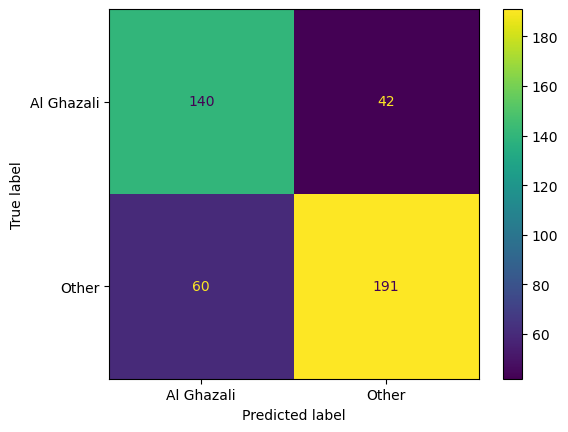

In [ ]:
cx=confusion_matrix(Test_Corpus_Data["prediction"],Test_Corpus_Data["author"])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cx, display_labels = ["Al Ghazali", "Other"])

cm_display.plot()
plt.show()

For book Al-Mankhul min Taliqat al-Usul


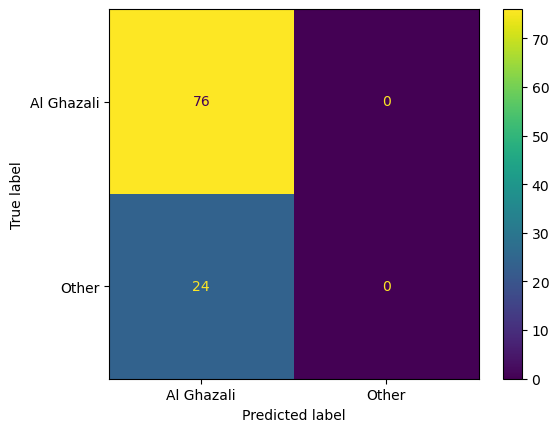

For book Al Mustasfa min ilm al-Usul


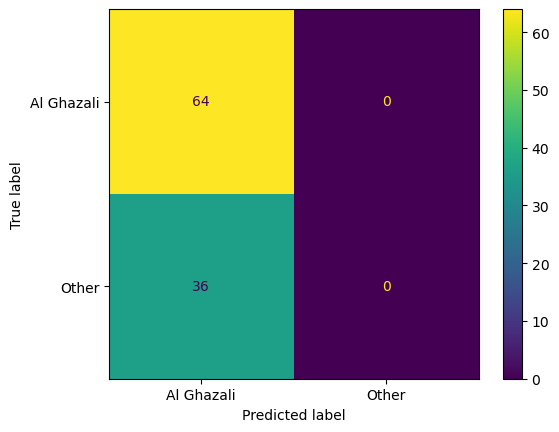

For book Ahliyi al-Madnun bihi ala ghayri


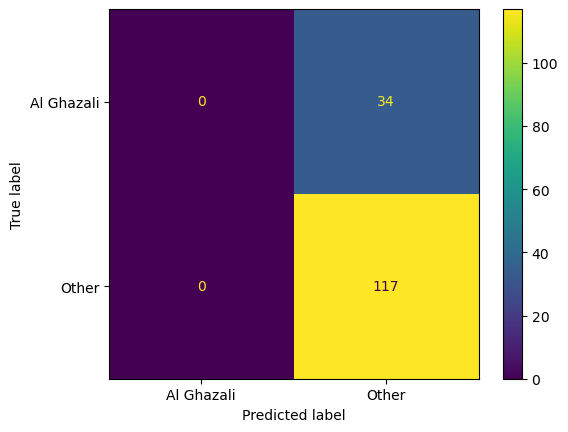

For book Kimiya-yi Saādat


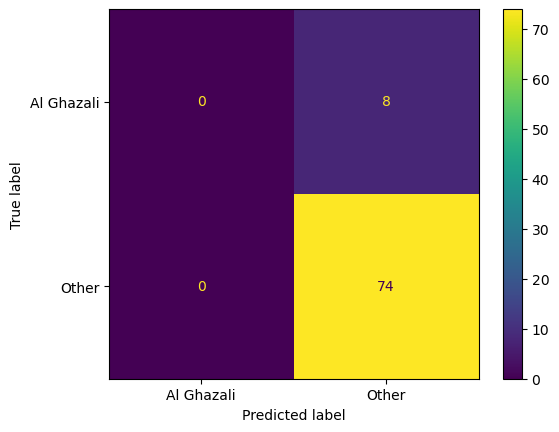

In [ ]:
for i in keys:
    print("For book "+i)
    testdata=Test_Corpus_Data.loc[Test_Corpus_Data['bookName'] == i]
    from sklearn.metrics import accuracy_score
    cx=confusion_matrix(testdata["prediction"],testdata["author"])
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cx, display_labels = ["Al Ghazali", "Other"])
    cm_display.plot()
    plt.show()


In [ ]:
for i in keys:
    testdata=Test_Corpus_Data.loc[Test_Corpus_Data['bookName'] == i]
    from sklearn.metrics import accuracy_score
    score=accuracy_score(testdata["prediction"],testdata["author"])
    print("The accuracy for book "+i+"is =" , score , "%")

The accuracy for book Al-Mankhul min Taliqat al-Usulis = 0.76 %
The accuracy for book Al Mustasfa min ilm al-Usulis = 0.64 %
The accuracy for book Ahliyi al-Madnun bihi ala ghayriis = 0.7748344370860927 %
The accuracy for book Kimiya-yi Saādatis = 0.9024390243902439 %
